# Principal Component Analysis

In this exercise sheet we look into how to compute and apply a Principal Component Analysis (PCA).

## Toy 4D Example

We start by loading our toy example. The data is stored as a Numpy array, it is a $2585\times 5$ matrix. The last component of each row is the label, the first four components are the coordinates in 4D. Each label is an integer from  $\{0, 1, 2, 3, 4\}$.

The data contains a noisy 2D plane which is embded into 4D. We would like to represent the data in its _intrinsic_ 2D form.

In [1]:
!pip install pillow  # install the Python package "pillow"
import numpy as np
import mllab.pca

Invalid requirement: '#'



In [2]:
pca_toy_4d = np.load("data/pca_toy_4d.npy")
y = pca_toy_4d[:, -1]  # labels
x = pca_toy_4d[:, :-1]  # 4D coordinates

Let us plot slices from this 4D data. We provide a helper function for this:

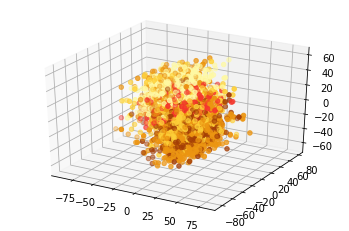

In [12]:
# Show documentation
mllab.pca.plot_toy_slice?
mllab.pca.plot_toy_slice(x, y, 0)

We want to remove the noise and recover the 2D information.

### Task 3.1

Write an implementation of the function below. Use a singular value decomposition (SVD), but avoid computing it completely since we only need the first $q$ eigenvectors. You can use a NumPy/SciPy function for this.

In [82]:
from scipy.sparse.linalg import svds
from numpy.linalg import svd, norm
def pca(x, q):
    """
    Compute principal components and the coordinates.
    
    Parameters
    ----------
    
    x: (n, d) NumPy array
    q: int
       The number of principal components to compute.
       Has to be less than `p`.

    Returns
    -------
    
    Vq: (d, q) NumPy array, orthonormal vectors (column-wise)
    xq: (n, q) NumPy array, coordinates for x (row-wise)
    """
    # your code here
    
    #find average of x data
    mu = np.mean(x, axis=0)
    
    #define our matrix X
    X = np.subtract(x, mu)
    
    #Compute singular values
    Vq = svds(X, q, return_singular_vectors = 'vh')[2]
    Vq = Vq.T   
    
    xq = Vq.T@X.T

    
    return Vq, xq.T

    

Now we can compute the 2D dimensional representation of `x` using PCA.

In [53]:
V, xq = pca(x, q=2)

(4, 2)
(2585, 2)


And then plot the coordinates `xq`, which are two dimensional. We provide a helper function for this task. Let us check how to use it:

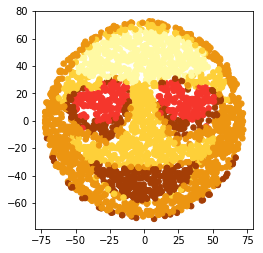

array([[-64.48531131,  19.64873417],
       [ 71.59642019, -12.65364158],
       [ 18.30057618, -66.35087369],
       ...,
       [ 13.85268789,  68.82870464],
       [ 35.7436977 , -27.05909592],
       [-26.27779499, -49.71007271]])

In [55]:
mllab.pca.plot_toy_2d(xq, y)

Hopefully you appreciate the result.

### Task 3.2

Let us see how PCA handles a non-linear transformation. To test this we map our data into 3D by keeping the y-axis as the new z-axis and bending x-coordinate onto an ellipse.

In [68]:
xyz = mllab.pca.map_on_ellipse(xq, a=4, b=4, gap_angle=90)

<IPython.core.display.Javascript object>


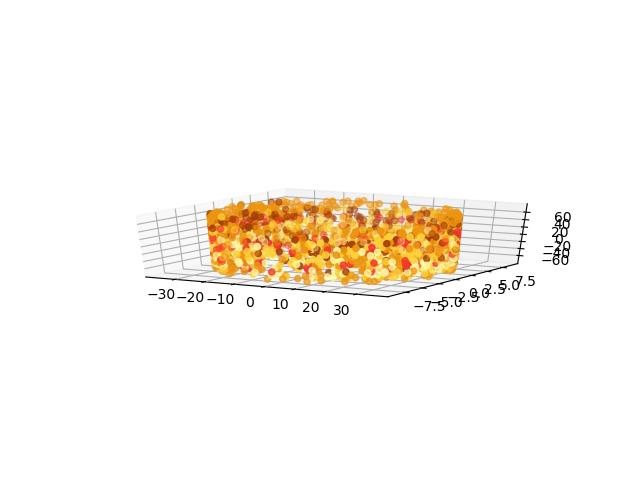

In [60]:
%matplotlib notebook
mllab.pca.plot_toy_3d(xyz, y)

**(Remeber to stop the interactive plot by pressing the shutdown icon!)**

Now apply PCA to our transformed data and plot the result as before.

(3, 2)
(2585, 2)


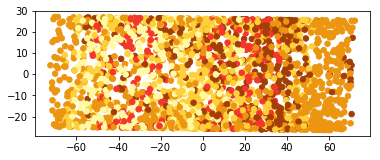

array([[ 44.0311333 ,  -0.42769766],
       [-53.14381257,   0.42242257],
       [ 20.46871374,  22.05860145],
       ...,
       [-48.51956136,  -4.62734041],
       [-15.25373336,  26.04761774],
       [ 48.88148129, -20.8768406 ]])

In [69]:
%matplotlib inline
# plot code here

V, xyzq = pca(xyz, q=2)
mllab.pca.plot_toy_2d(xyzq, y)


Could be worse, but undeniably discomforting. Try different axes lengths and gap sizes of the ellipse. What do you observe?

### Task 3.3

We want to see if PCA can improve the accuracy of separating hyperlanes. First compute the singular values of the Iris dataset, then check how many percent of the variance the first two principal components capture.

In [89]:
from sklearn.datasets import load_iris
iris = load_iris()
iris_x = iris['data']
iris_y = iris['target']

In [85]:
sin_vals = svd(iris_x, compute_uv=False)
print(sin_vals)
var = np.square(sin_vals)
print(var)

princ_comp_1 = var[0]/np.sum(var)
print(princ_comp_1)
princ_comp_2 = (var[0]+var[1])/np.sum(var)
print(princ_comp_2)

[95.95991387 17.76103366  3.46093093  1.88482631]
[9.20830507e+03 3.15454317e+02 1.19780429e+01 3.55257020e+00]
0.9653029806531566
0.9983719319668035


Now apply PCA and compute the first two principal components. Plot the projected 2D data in a scatter plot such that the three labels are recognizable. What do you observe?

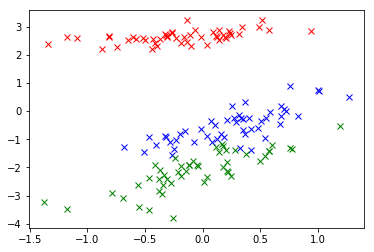

In [110]:
import matplotlib.pyplot as plt

V, x = pca(iris_x, 2)

plt.plot(x[:50,0],x[:50,1], 'rx')
plt.plot(x[50:100,0],x[50:100,1], 'bx')
plt.plot(x[100:150,0],x[100:150,1], 'gx')

In [99]:
def plot_1d_iris(a, b, c):
    """Show a 1D plot of three 1D datasets a, b and c.
    
    Top to bottom plotted in order is a, b, c."""
    left = min(x.min() for x in (a, b, c))
    right = max(x.max() for x in (a, b, c))
    for i, (x, c) in enumerate(((a, 'red'), (b, 'blue'), (c, 'green'))):
        plt.hlines(i * .3, left, right, linestyles='dotted', colors=[(.8,.8,.8,1)])
        plt.eventplot(x, colors=c, linewidths=.5, linelengths=.25, lineoffsets=(2 - i) * .3)
    plt.axis('off')

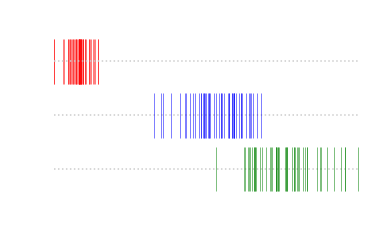

In [109]:
V, x = pca(iris_x, 1)
x = x.flatten()

plot_1d_iris(x[:50], x[50:100],x[100:150])

Finally, recompute the accurancy as in sheet 1 and compare the results.

In [111]:
from numpy.linalg import lstsq
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC

def labels(x1, x2):
    return np.concatenate((np.zeros(x1.shape[0], dtype='int'), np.ones(x2.shape[0], dtype='int')))

In [153]:
# add your code here

def run_SVMs(x):
    #Separating data points with label 0 from 1,2
    y = labels(x[0:50,:], x[50:150,:])
    SVC_4D = LinearSVC()
    SVC_4D.fit(x, y)
    y_predict1 = SVC_4D.predict(x)

    #Separating data points with labels 1 and 2
    x2=x[50:150,:]
    y = labels(x[50:100,:], x[100:150,:])
    SVC_4D = LinearSVC(max_iter=10000)
    SVC_4D.fit(x2, y)
    y_predict2 = SVC_4D.predict(x2) +1

    #concatenate predicted labels from the two SVM runs
    y_predict = np.concatenate((y_predict1[:50], y_predict2))
    return y_predict

In [160]:
#4D example
x = iris_x
y = iris_y
y_predict = run_SVMs(x)
confusion_matrix(y, y_predict)
print(accuracy_score(y, y_predict))

#2D example
x= pca(iris_x,2)[1]
y = iris_y
y_predict = run_SVMs(x)
confusion_matrix(y, y_predict)
print(accuracy_score(y, y_predict))

#1D example
x= pca(iris_x,1)[1]
y = iris_y
y_predict = run_SVMs(x)
confusion_matrix(y, y_predict)
print(accuracy_score(y, y_predict))

0.98
0.9733333333333334
0.9333333333333333


## Pedestrian Classification

__Read the pedestrian dataset into a NumPy array and normalize to [0,1]__

In [ ]:
import mllab.pca
mllab.pca.load_pedestrian_images?

__Write a function to plot an image__

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_im(im, ax=None, title=None, max_contrast=False):
    """
    Plot a normalized image.
    
    Parameters
    ----------
    
    im: (1250,) array-like
    """
    # your code here

__Plot 10 randomly chosen images showing a pedestrian, and 10 randomly chosen images not showing a pedestrain__

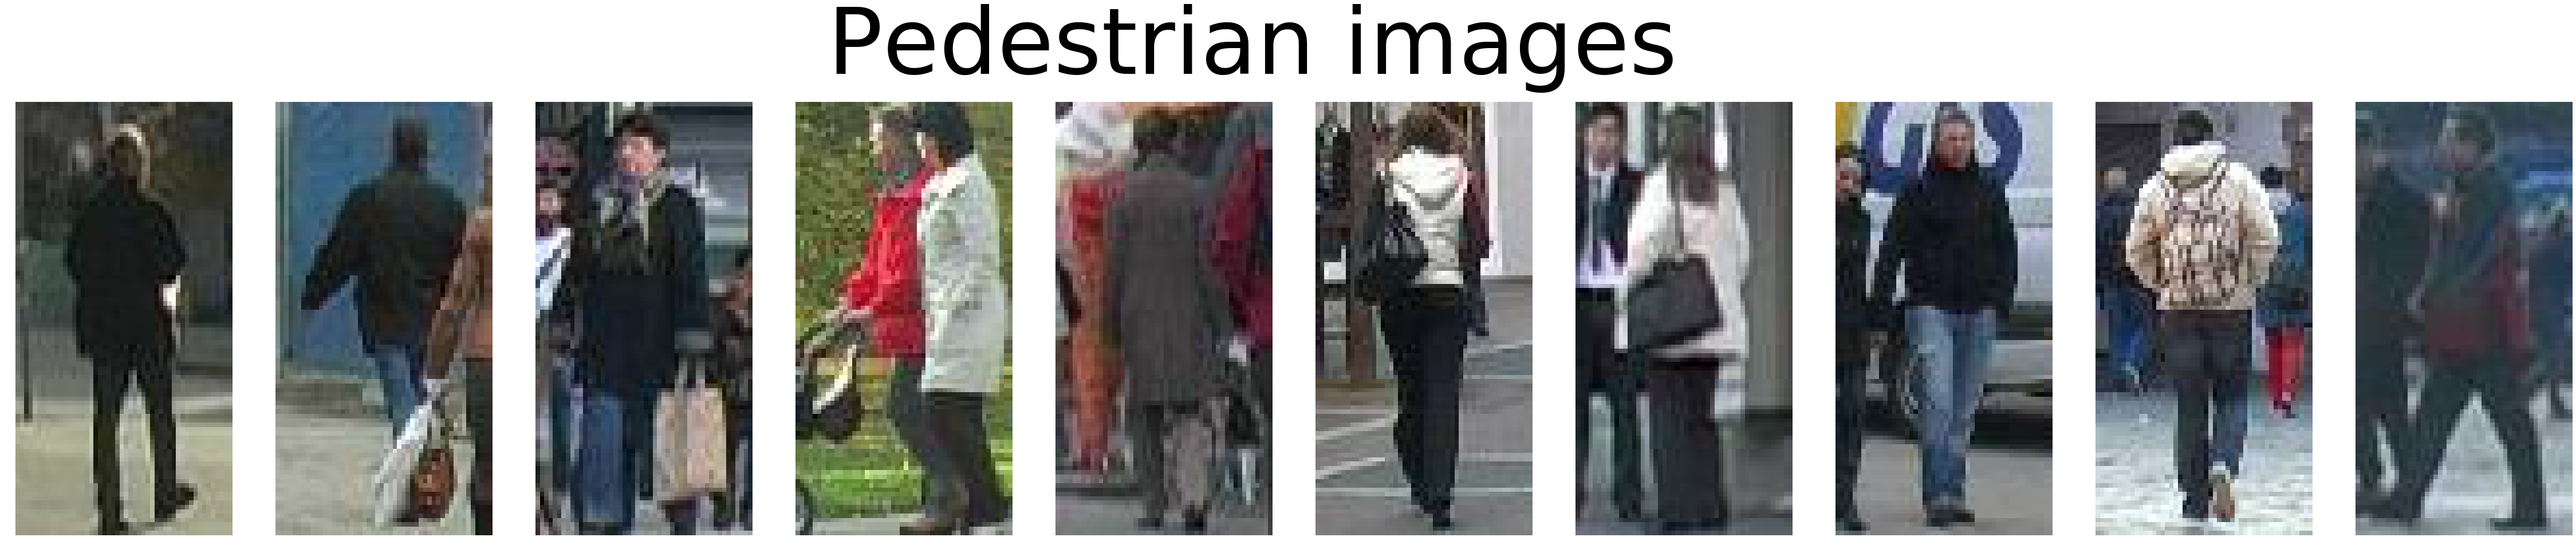

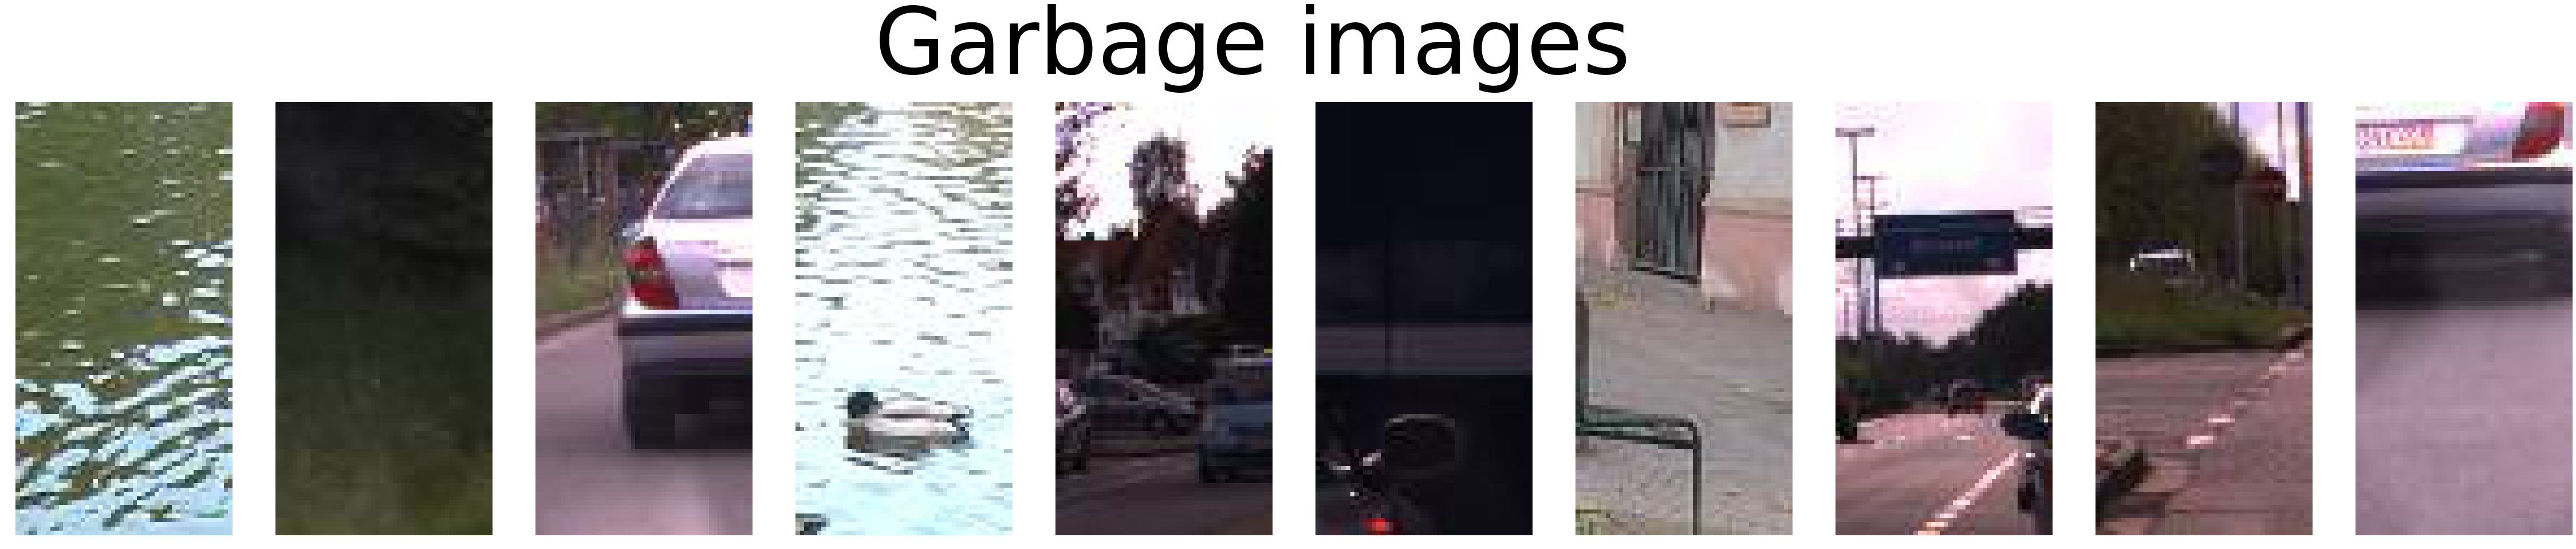

In [ ]:
# your code here

__Compute the PCA of the full training set for $q=200$__

In [ ]:
from sklearn.decomposition import PCA

PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

__Plot the eigenpedestrian 1-20, 51-60, and 111-120__

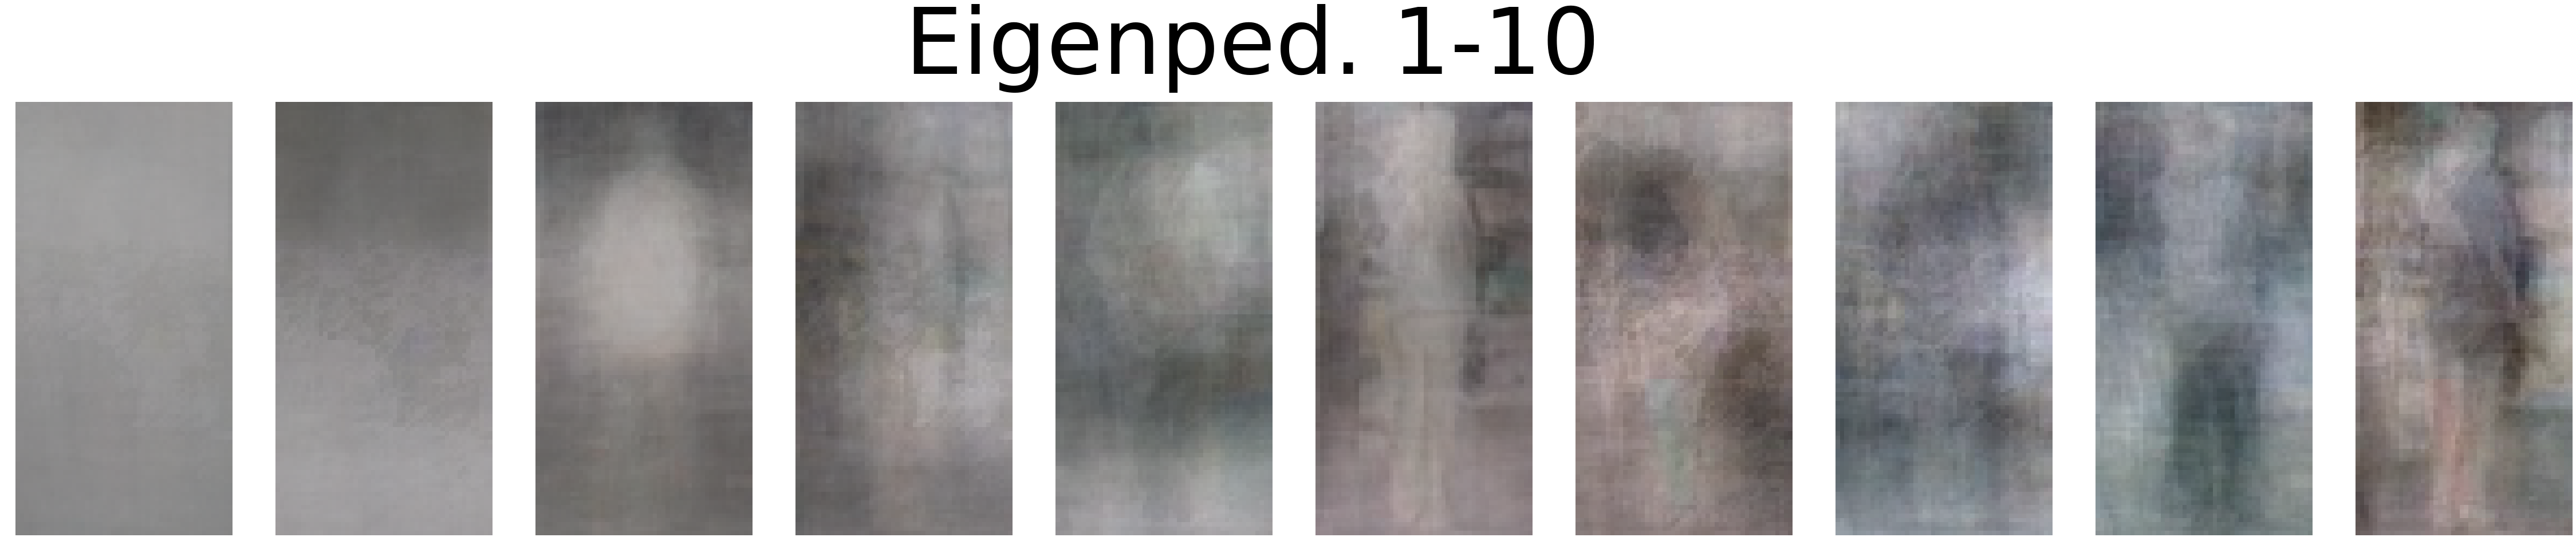

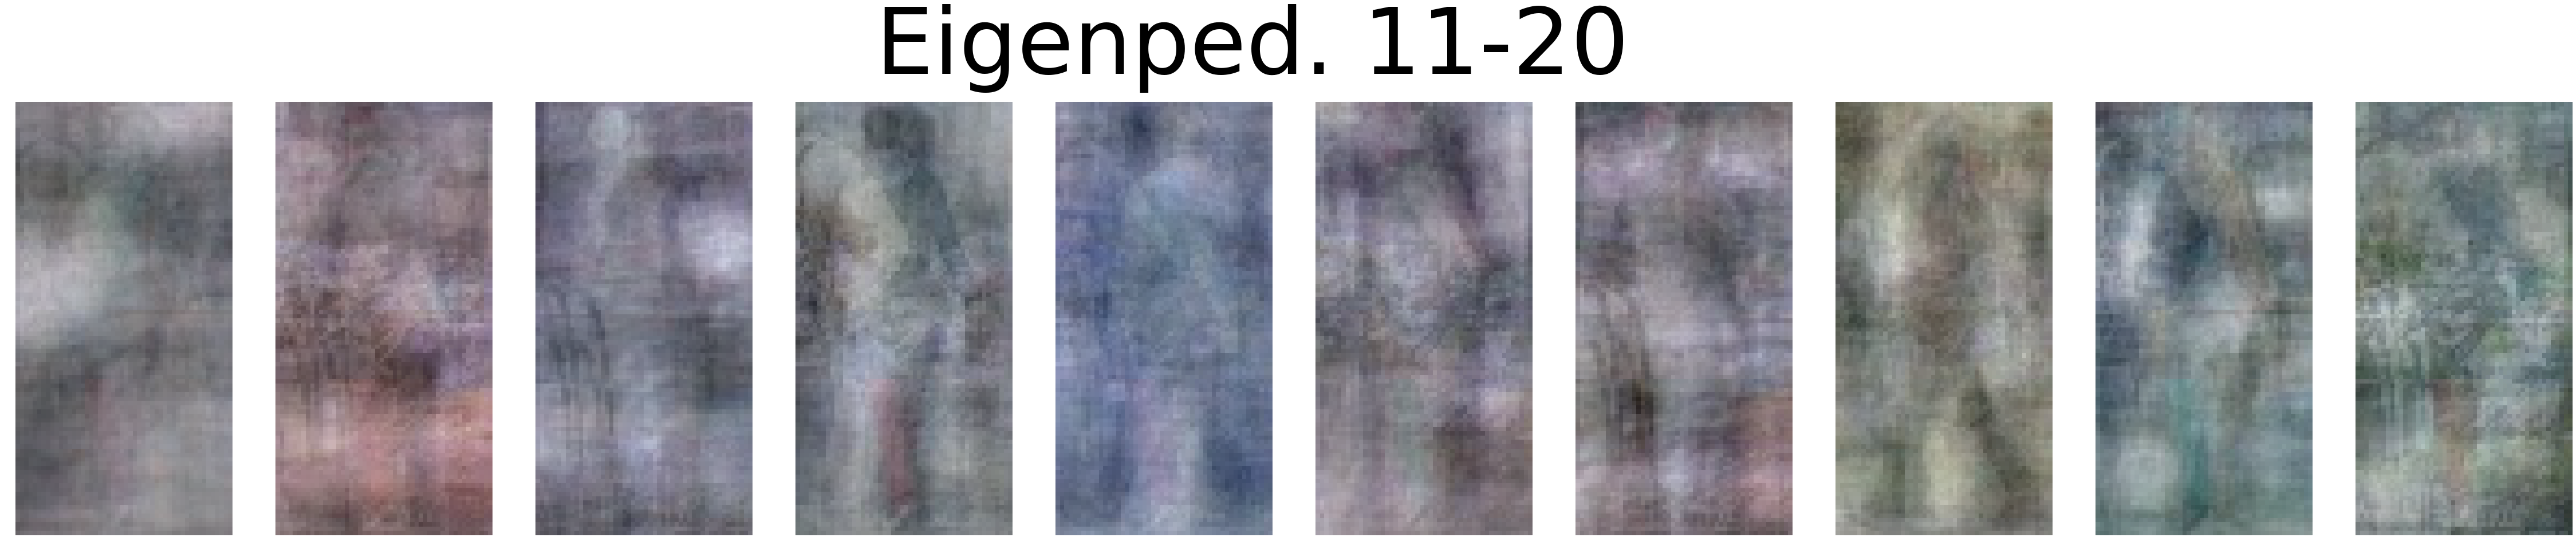

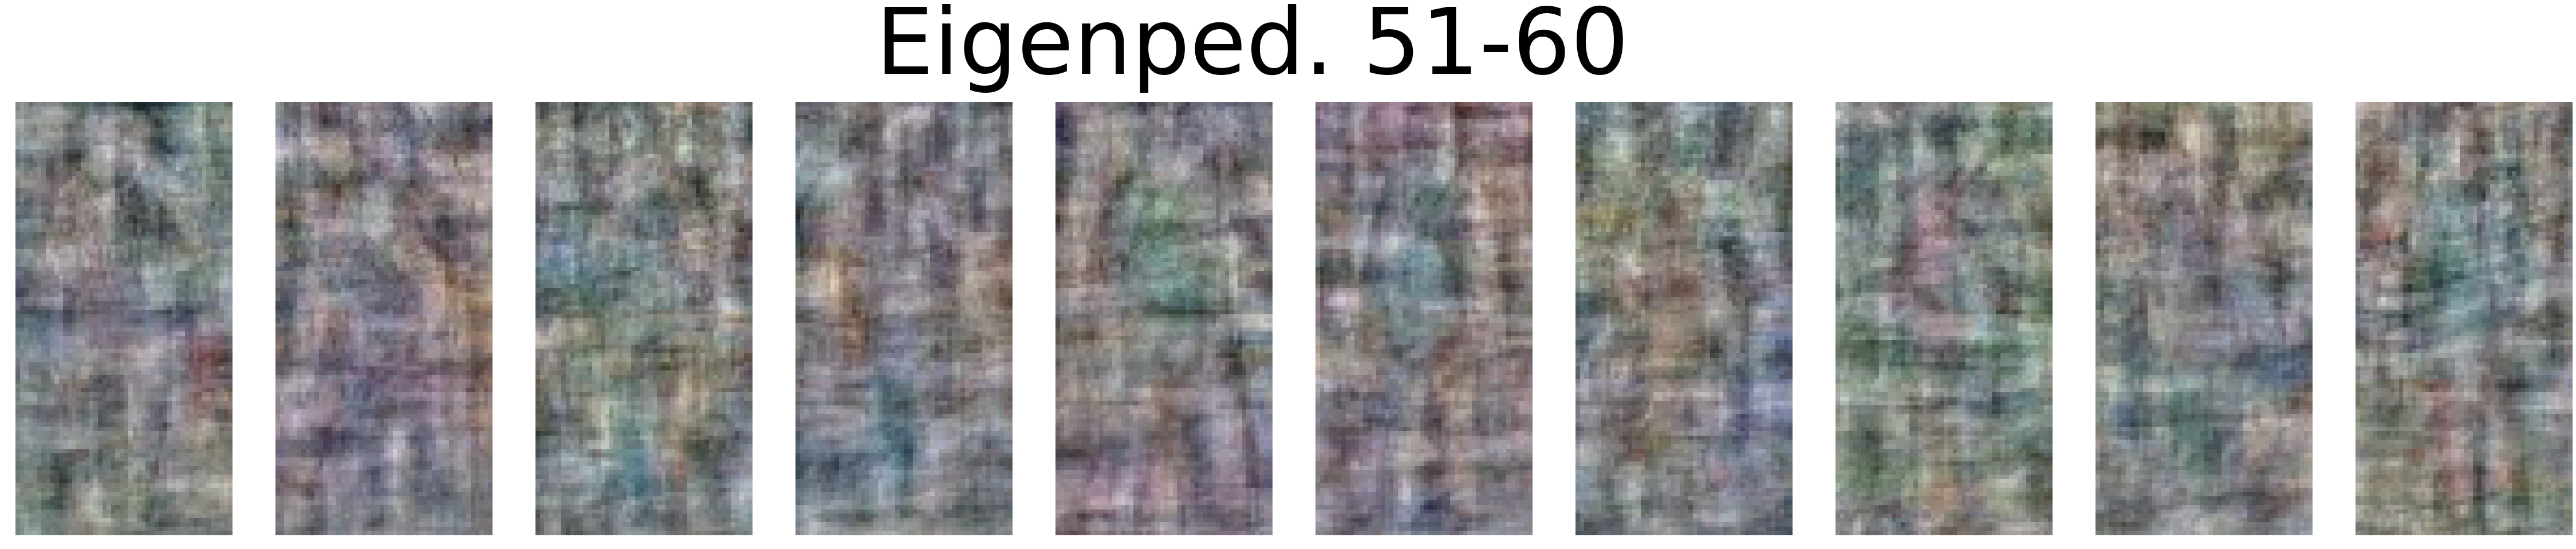

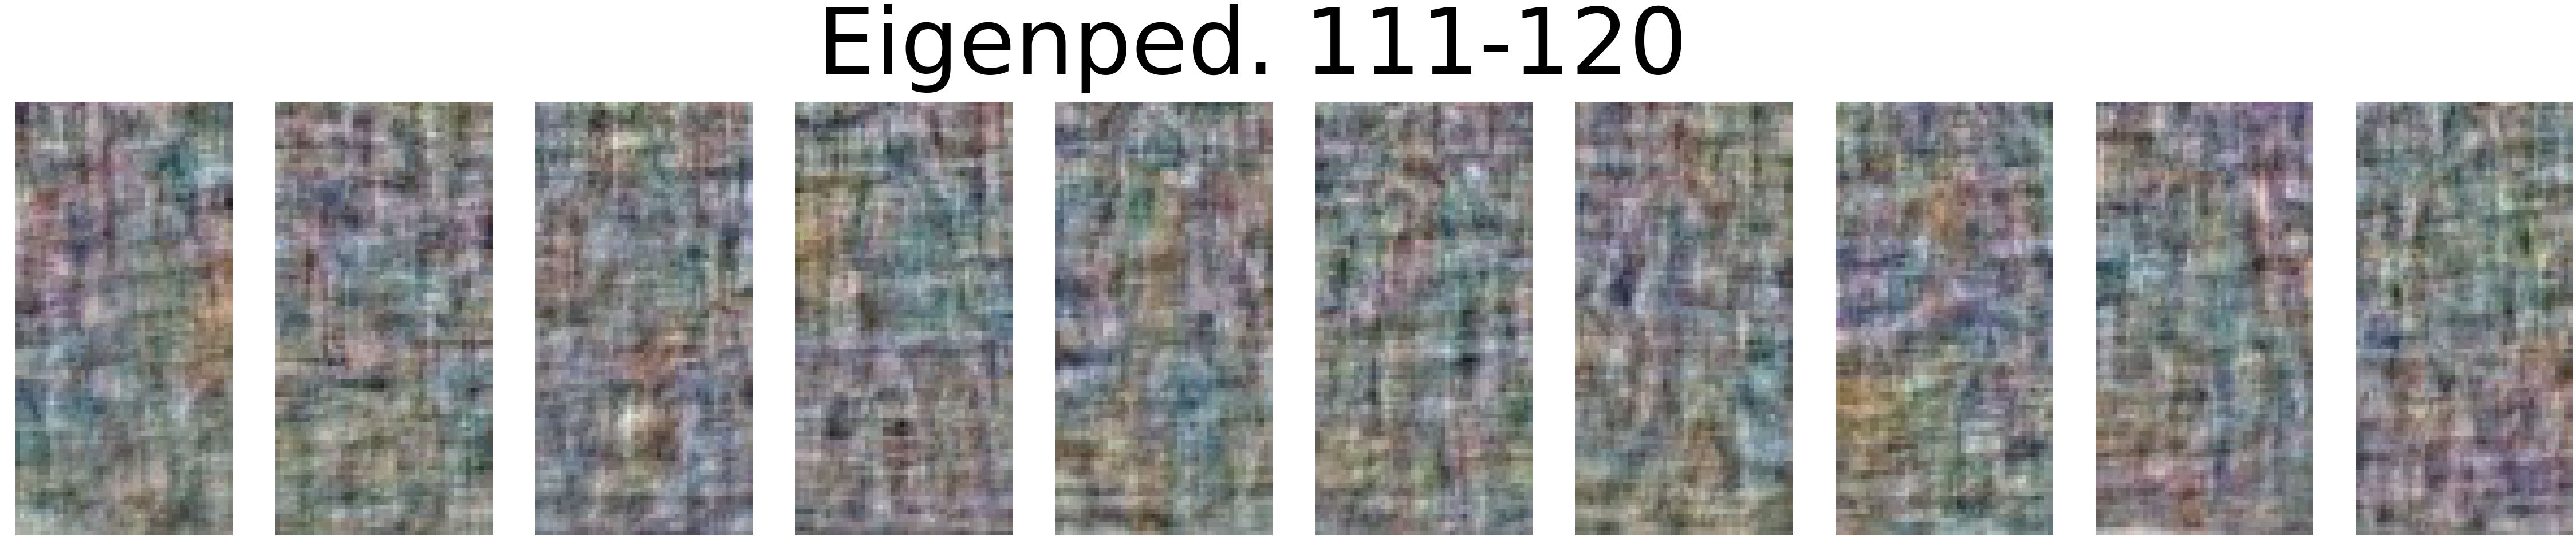

__Compute the scores for a linear SVM using increasing numbers of principal components__

Use 10 to 200 components in steps of 5. Train the linear SVM with $C=0.01$ and increse the maximum number of iterations for the solver. You can reuse the computed PCA from above.

In [ ]:
from sklearn.svm import LinearSVC

10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 

35

Plot the training and test scores over $q$.

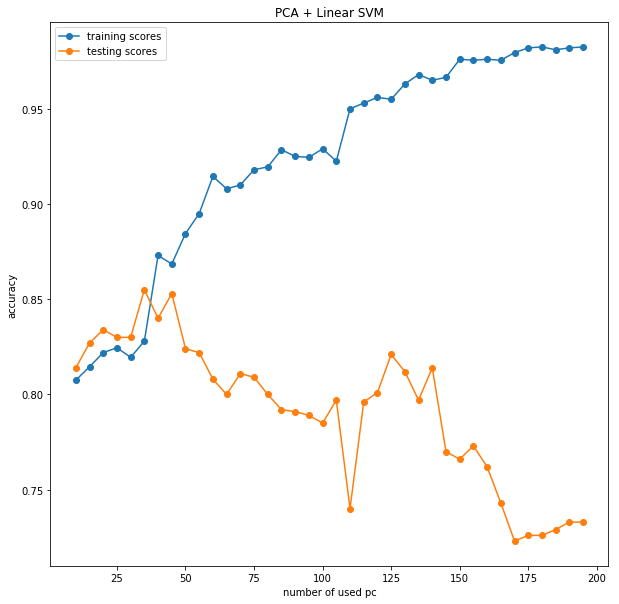

### HOG Features

__Implement the HOG features, or create a binding to the C++ code__

In [ ]:
import numpy as np
import scipy.ndimage as ndimage
from numpy.linalg import norm
from scipy.ndimage.filters import convolve


class HogFeatures:
    def __init__(self, im_shape, n_bins=9, cell_size=8, blk_size=2, unsigned=True, clip_val=.2):
        self.deg_range = np.pi if unsigned else 2 * np.pi
        self.n_bins = n_bins
        self.bins = np.linspace(0, self.deg_range, n_bins, endpoint=False)
        self.bin_size = self.deg_range / n_bins
        self.cell_size = cell_size
        self.blk_size = blk_size
        self.clip_val = clip_val
    
    def extract(self, im):
        """
        Extract the HOG features for a image.
        
        Parameters
        ----------
        
        im: ndarray
            An array of shape (height, width, 3).
        """
        # your code here. use self.<name> to access the values stored in __init__

To test you Python implementation we provide some intermediate steps. The array `image` is the input, and `steps` contains the values of the inner variables of the HOG algorithm. The image is grayscale.

In [ ]:
image, steps = mllab.pca.hog_test_data()

Number of bins: 9
Cell size: 8
Block size: 2
Unsigned directions: True
Clip value: 0.2


In [ ]:
try:
    # Is there a C++ binding?
    import hog
    print("Use C++ implementation")
except ModuleNotFoundError:
    # Use Python implementation
    hog = HogFeatures((100, 50))
    print("Use Python implementation")

__Compute the HOG features for the training data, then compute the PCA for $q=200$.__

100%|██████████| 2000/2000 [02:01<00:00, 16.68it/s]


Computed HoG.


PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

__Compute and plot the scores as above, but this time use the HOG features.__

10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 

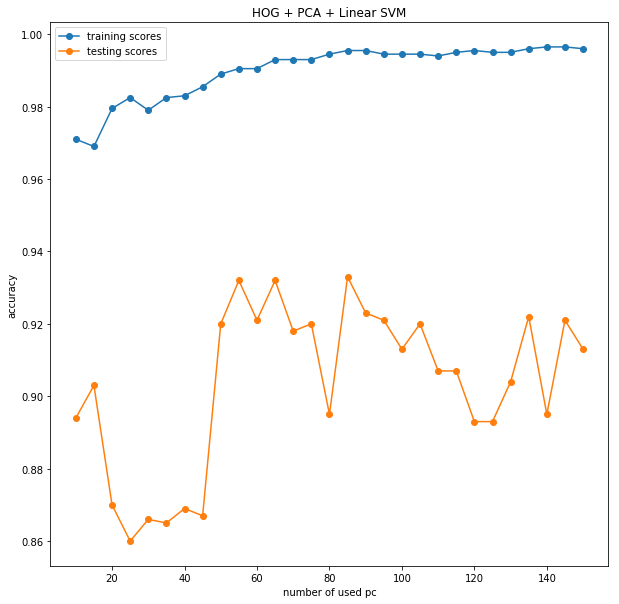

In [ ]:
# plot code